<a href="https://colab.research.google.com/github/ClauACuellar/Index/blob/main/Robot_Trading.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Robot_Trading**:)

# **Desafío**

¿Estás preparado? He escogido para tí, un gran proyecto, prometo que no será difícil, pero tampoco será fácil! 😉

Vamos a contruir un Robot Trading en Python capaz de tomar decisiones de compra y venta de Bitcoin en tiempo real, ¿interesante verdad?,


## 1. Configuracion del Ambiente

1. Configuración del ambiente: Para empezar, puedes utilizar un entorno virtual como Google Colaboratory, o si deseas, puedes usar el editor Python de tu preferencia, sólo asegúrate de tener Python 3.x instalado en tu computadora. También necesitarás instalar algunas librerías de Python que son esenciales para este proyecto, como Pandas, Numpy, Matplotlib, etc.

In [1]:

!python -V
print('------')
!pip show Pandas | grep 'Name\|Version'
print('------')
!pip show Numpy | grep 'Name\|Version'
print('------')
!pip show Matplotlib | grep 'Name\|Version'



Python 3.10.12
------
Name: pandas
Version: 2.0.3
------
Name: numpy
Version: 1.25.2
------
Name: matplotlib
Version: 3.7.1


In [2]:
import pandas as pd #Para analisis de DF
from bs4 import BeautifulSoup #Extraccion de los datos de la pagina web
import requests #Para que llame la pagina web
import matplotlib.pyplot as plt #Graficas
import numpy as np #Para la parte numerica
import json
import time

global df_bitcoin, precio_actual, tendencia, media_bitcoin, algoritmo_decision, alta, baja #Declaro las variables globales
precio_actual= []
tendencia=[]
media_bitcoin=[]
algoritmo_decision=[]
alta=[]
baja=[]

## 2. Obtención de Datos


2. Obtención de datos: Necesitarás acceder a una API que proporcione datos históricos de precios de Bitcoin en formato JSON. Por otro lado, necesitarás realizar Web Scraping en un site de noticias para obtener el precio actual y algunos indicadores de tendencias del Bitcoin.

In [3]:
!pip install yfinance


In [4]:
import yfinance as yf
btc_usd = yf.Ticker("BTC-USD")
# Obteniendo la informacion
btc_info= btc_usd.info
for line in btc_info.items():
  print(':', line)


: ('name', 'Bitcoin')
: ('startDate', 1278979200)
: ('description', 'Bitcoin (BTC) is a cryptocurrency launched in 2010. Users are able to generate BTC through the process of mining. Bitcoin has a current supply of 19,674,625. The last known price of Bitcoin is 67,897.22799681 USD and is up 1.73 over the last 24 hours. It is currently trading on 10957 active market(s) with $28,511,184,103.78 traded over the last 24 hours. More information can be found at https://bitcoin.org/.')
: ('maxAge', 86400)
: ('priceHint', 2)
: ('previousClose', 67845.94)
: ('open', 67845.94)
: ('dayLow', 67532.99)
: ('dayHigh', 68395.81)
: ('regularMarketPreviousClose', 67845.94)
: ('regularMarketOpen', 67845.94)
: ('regularMarketDayLow', 67532.99)
: ('regularMarketDayHigh', 68395.81)
: ('volume', 20392849408)
: ('regularMarketVolume', 20392849408)
: ('averageVolume', 34537022141)
: ('averageVolume10days', 32586859287)
: ('averageDailyVolume10Day', 32586859287)
: ('marketCap', 1344647856128)
: ('fiftyTwoWeekLow

In [5]:
btc_info['coinMarketCapLink']
#datos_html = pd.read_html('coinmarketcap.com/currencies/bitcoin/historical-data/')
# get historical market data


'https://coinmarketcap.com/currencies/bitcoin'

In [34]:
def importar_base_bitcoin():
  global df_bitcoin, precio_actual, tendencia, media_bitcoin, algoritmo_decision
  df_bitcoin= pd.DataFrame(btc_usd.history(period="7d", interval="5m"))
  df_bitcoin.to_json('df_bitcoin.json')







In [35]:
#LLamar la funcion
importar_base_bitcoin()


In [37]:
#Validación
print(type(df_bitcoin))
print("Cantidad de Filas y Columnas del DF df_bitcoin:", df_bitcoin.shape)
df_bitcoin.head()

<class 'pandas.core.frame.DataFrame'>
Cantidad de Filas y Columnas del DF df_bitcoin: (1951, 7)


,Open,High,Low,Close,Volume,Dividends,Stock Splits
Datetime,,,,,,,
2024-03-31 00:00:00+00:00,69647.742188,69661.390625,69647.742188,69656.429688,0,0.0,0.0
2024-03-31 00:05:00+00:00,69665.023438,69742.867188,69665.023438,69742.867188,23811072,0.0,0.0
2024-03-31 00:10:00+00:00,69721.281250,69738.117188,69721.281250,69728.140625,0,0.0,0.0
2024-03-31 00:15:00+00:00,69754.882812,69903.968750,69754.882812,69885.828125,43395072,0.0,0.0
2024-03-31 00:20:00+00:00,69872.640625,69928.828125,69867.148438,69923.289062,22921216,0.0,0.0


In [7]:
url = 'https://coinmarketcap.com/'

# Realizar solicitud GET a la página web
response = requests.get(url)

# Comprobar si la solicitud fue exitosa
response.status_code == 200

True

In [8]:

def extraer_tendencias(url):
#url = 'https://coinmarketcap.com/' favor digitar esta url cuando llame la funcion
  global precio_actual, tendencia, media_bitcoin, algoritmo_decision, precio_bitcoin, precio_bitcoins, precio_bitcoin_2,cambio_1h,cambio_1h_dic

  respuesta = requests.get(url)
  s=BeautifulSoup(respuesta.content, "lxml") #leer la pagina y guardarlo la pagina en lxml


#se toman del producto boton derecho en la pagina web e inspeccionar y copio
  #como el primero es Bitcoin se hace solo con  find:
  #<div class="sc-500f568e-0 ejtlWy"><a href="/currencies/bitcoin/#markets" class="cmc-link"><span>$67,899.92</span></a></div>

  precio_bitcoins= s.find('div', {'class': "sc-500f568e-0 ejtlWy"})
  precio_bitcoin_2 =precio_bitcoins.find('span')
  for precio_bitcoins in precio_bitcoins:
    precio_actual_texto = precio_bitcoin_2.get_text().strip().replace("<span>","").replace("</span>","").replace("$","").replace(",","")
    precio_actual = float( precio_actual_texto)#Convertimos a float.

#se toman del producto boton derecho en la pagina web e inspeccionar y copio estan 2 clases asi:
  #<span class="sc-6a54057-0 YXxPZ"><span class="icon-Caret-up" style="width:12px;height:18px;display:inline-block"></span>0.19%</span>
  #<span class="sc-6a54057-0 iEhQde"><span class="icon-Caret-down" style="width: 12px; height: 18px; display: inline-block;"></span>0.22%</span>
#Formula para dos  clases, como el primero es Bitcoin se hace solo con  find:
  #respuesta = s.findAll('span', {'class':['clase1','clase2','clase3']})

  cambio_1h = s.find('span', {'class':['sc-6a54057-0 YXxPZ','sc-6a54057-0 iEhQde']})
  cambio_1h_dic =  cambio_1h.attrs #Convertimos a diccionario

  for cambio in cambio_1h :
    texto = cambio.get_text().strip()


#Determinemos la tendencia
  if 'iEhQde' in cambio_1h_dic.get('class', []):
    tendencia = "Baja"
  elif 'YXxPZ' in cambio_1h_dic.get('class', []):
    tendencia = "Alta"
  else:
    tendencia = "Desconocida"



  print('La variacion de ultima hora:',texto)
  print('Tendencia', tendencia)
  print('El Precio actual de Bitcoin (USD):',precio_actual )
  #Validaciones
  print(cambio_1h)
  print(cambio)



In [33]:
#Llamar la función
extraer_tendencias('https://coinmarketcap.com/')

La variacion de ultima hora: 0.13%
Tendencia Alta
El Precio actual de Bitcoin (USD): 68292.87
<span class="sc-6a54057-0 YXxPZ"><span class="icon-Caret-up" style="width:12px;height:18px;display:inline-block"></span>0.13%</span>
0.13%


## 3. Limpieza de Datos



3. Limpieza de datos: Una vez que tengas los datos históricos deberás cargarlos en un DataFrame de Pandas para poder manipularlos y analizarlos, deberás identificar y eliminar los outliers, además de tratar cualquier valor nulo o duplicados en la base. Finalmente, con la base limpia, calcula el precio promedio del Bitcoin.

In [10]:

#crea una copia de la base df_bitcoin para que realices la limpieza en esta nueva base(df_bitcoin_limpio), sin modificar la base original,
print(type(df_bitcoin))
print(df_bitcoin.shape)
df_bitcoin_limpio = df_bitcoin.copy()
print(df_bitcoin_limpio.shape)
print(df_bitcoin_limpio.info())
df_bitcoin_limpio.head()

<class 'pandas.core.frame.DataFrame'>
(1945, 7)
(1945, 7)
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1945 entries, 2024-03-31 00:00:00+00:00 to 2024-04-06 18:00:00+00:00
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          1945 non-null   float64
 1   High          1945 non-null   float64
 2   Low           1945 non-null   float64
 3   Close         1945 non-null   float64
 4   Volume        1945 non-null   int64  
 5   Dividends     1945 non-null   float64
 6   Stock Splits  1945 non-null   float64
dtypes: float64(6), int64(1)
memory usage: 186.1 KB
None


,Open,High,Low,Close,Volume,Dividends,Stock Splits
Datetime,,,,,,,
2024-03-31 00:00:00+00:00,69647.742188,69661.390625,69647.742188,69656.429688,0,0.0,0.0
2024-03-31 00:05:00+00:00,69665.023438,69742.867188,69665.023438,69742.867188,23811072,0.0,0.0
2024-03-31 00:10:00+00:00,69721.281250,69738.117188,69721.281250,69728.140625,0,0.0,0.0
2024-03-31 00:15:00+00:00,69754.882812,69903.968750,69754.882812,69885.828125,43395072,0.0,0.0
2024-03-31 00:20:00+00:00,69872.640625,69928.828125,69867.148438,69923.289062,22921216,0.0,0.0


In [17]:
#Para la limpieza utilizaremos los atributos Datetime, Close y Volume.
def limpieza_datos():

  global duplicados_ind, sin_duplicados_ind, df_sin_nulos_close, media_bitcoin, df_remover,df_filtrado
  #identifica duplicados en el índice y trátalos para quedarte con sólo índices únicos.
  duplicados_ind = df_bitcoin_limpio.index.duplicated(keep='first')

    # Tratar los duplicados en el índice eliminando las filas duplicadas
  sin_duplicados_ind = df_bitcoin_limpio[~duplicados_ind]

  #Luego busca por valores nulos en la columna Close y trátalos.
  if 'Close' in sin_duplicados_ind.columns:
    sin_nulos_close  = sin_duplicados_ind['Close'].isnull().sum()
    print(f"Numero de valores nulos en la columna 'Close' : {sin_nulos_close}")
    if sin_nulos_close == 0:
      print("No hacer tratamiento de nulos")
    else:
      df_sin_nulos_close = sin_duplicados_ind.dropna(subset=['Close'])
      print("\nDataFrame después de tratar los valores nulos:")
  else:
    print("En la columna  'Close' no se encontraron  nulos in DF")

  df_sin_nulos_close = sin_duplicados_ind.dropna(subset=['Close'])

  #Verifica que todos los registros de la base tengan un Volume de transacción mayor a 0, caso contrário, elimínalos.
  df_remover = df_sin_nulos_close.query("Volume == 0").index
  print("Datos a remover:", df_remover.shape)

  df_sin_nulos_close.drop(df_remover, axis=0,inplace=True)
  print("Datos despues de quitar los ceros en volumen:" ,df_sin_nulos_close.shape)

  #Deberás identificar y eliminar los outliers en el precio del Bitcoin, columna Close, utiliza un gráfico de boxplot para identificarlos.
  # Crear un gráfico de boxplot para identificar outliers
  plt.figure(figsize=(10, 6))
  df_sin_nulos_close.boxplot(column=['Close'])
  plt.title('Boxplot de Precio del Bitcoin (Close)')
  plt.ylabel('Precio (USD)')
  plt.grid(False)
  plt.show()

  # Identificar los outliers
  Q1 = df_sin_nulos_close['Close'].quantile(0.25)
  Q3 = df_sin_nulos_close['Close'].quantile(0.75)
  IQR = Q3 - Q1

  outliers = (df_sin_nulos_close['Close'] < (Q1 - 1.5 * IQR)) | (df_sin_nulos_close['Close'] > (Q3 + 1.5 * IQR))

    # Eliminar los outliers
  df_sin_outliers = df_sin_nulos_close[~outliers]
  print("Total del DF sin Outliers:" , df_sin_outliers.shape)
  print("Info del DF sin Outliers:" ,df_sin_outliers.info())

  #Filtra o selecciona únicamente los registros cuyo precio(Close) se encuentren entre el 1er cuartil(Q1) y el 3er cuartil(Q3) del boxplot.
    #df_sin_outliers

  Q1 = df_sin_outliers['Close'].quantile(0.25)
  Q3 = df_sin_outliers['Close'].quantile(0.75)

  # Filtrar los registros cuyo precio se encuentra entre Q1 y Q3
  df_filtrado = df_sin_outliers[df_sin_outliers['Close'].between(Q1, Q3)]

    # Mostrar el DataFrame filtrado
  print("Registros cuyo precio se encuentra entre Q1 y Q3:")
  print("Total del DF sin Outliers 1 y 3 Q:" , df_filtrado.shape)
  print("Info del DF sin Outliers 1 y 3 Q:" ,df_filtrado.info())

  #Finalmente, calcula el precio promedio(Close) de esta selección y guárdala en la variable media_bitcoin.
  media_bitcoin = df_filtrado['Close'].mean()

  df_filtrado



Numero de valores nulos en la columna 'Close' : 0
No hacer tratamiento de nulos
Datos a remover: (920,)
Datos despues de quitar los ceros en volumen: (1025, 7)


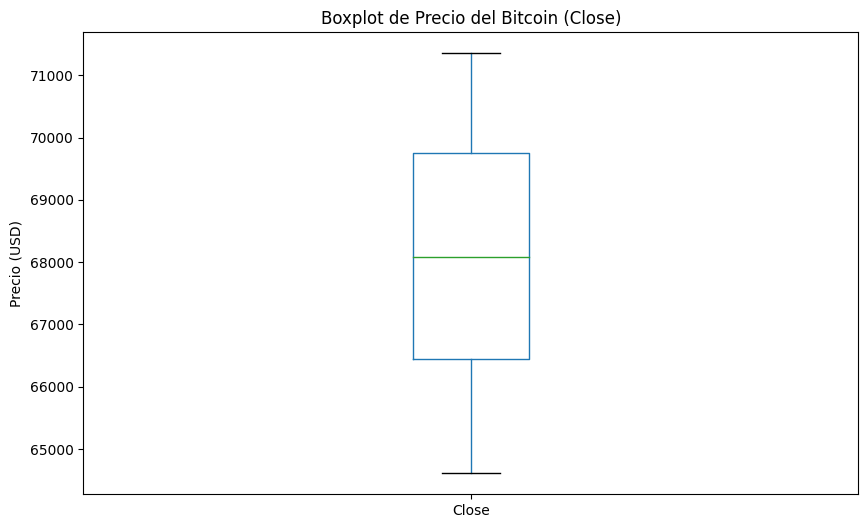

Total del DF sin Outliers: (1025, 7)
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1025 entries, 2024-03-31 00:05:00+00:00 to 2024-04-06 18:00:00+00:00
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          1025 non-null   float64
 1   High          1025 non-null   float64
 2   Low           1025 non-null   float64
 3   Close         1025 non-null   float64
 4   Volume        1025 non-null   int64  
 5   Dividends     1025 non-null   float64
 6   Stock Splits  1025 non-null   float64
dtypes: float64(6), int64(1)
memory usage: 64.1 KB
Info del DF sin Outliers: None
Registros cuyo precio se encuentra entre Q1 y Q3:
Total del DF sin Outliers 1 y 3 Q: (513, 7)
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 513 entries, 2024-03-31 00:05:00+00:00 to 2024-04-06 18:00:00+00:00
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Op

In [31]:
#Llamando la funcion creada
limpieza_datos()

## 4. Toma de decisiones


4. Tomar decisiones: Una vez que tengas el precio promedio, compáralo con el precio actual y tendencia del Bitcoin, que previamente obtuviste con Web Scraping. Si el precio actual es mayor/igual que la media y la tendencia es de baja, entonces se debe vender, pero si el precio actual es menor que la media y la tendencia es de alta, entonces se debe comprar.

In [32]:
def tomar_decisiones():

  global algoritmo_decision, precio_actual, media_bitcoin, tendencia, resultado


  if precio_actual >= media_bitcoin and tendencia == "Baja":
    resultado = "Vender"
  elif precio_actual <= media_bitcoin and tendencia == "Alta":
    resultado = "Comprar"
  else:
    resultado = "Esperar"
  #print("La decision es", resultado)
  return resultado

algoritmo_decision=tomar_decisiones()


In [29]:
#Validacion

print('Precio Promedio Bitcoin:',media_bitcoin)
print('Precio Actual Bitcoin:',precio_actual)
print('Tendencia:',tendencia)
print('Decisión del algoritmo:',algoritmo_decision)


Precio Promedio Bitcoin: 68127.99567495126
Precio Actual Bitcoin: 68294.97
Tendencia: Alta
Decisión del algoritmo: Esperar


## 5. Visualización de Datos

5. Visualización: Utiliza la librería Matplotlib para crear un gráfico donde se muestre la evolución del precio del Bitcoin durante el periodo seleccionado, y una línea recta que pase sobre el precio medio. Por último, muestra un mensaje en el gráfico que indique “Vender”, “Comprar” o “” según sea la decisión del algoritmo.

In [30]:
algoritmo_decision

'Esperar'

In [79]:

def visualizacion():
  global df_bitcoin, algoritmo_decision, precio_actual, media_bitcoin, tendencia
  #Adiciona una nueva columna (Promedio) al dataframe original df_bitcoiny almacena el valor de nuestra variable media_bitcoin
  df_bitcoin['Promedio'] = df_bitcoin['Close'].mean()

  # Configurar el tamaño del gráfico en una proporción de 16x5
  plt.figure(figsize=(16, 5))

  # Añadir un título al gráfico
  plt.title('Robot_Trading')

  # Dibujar una línea con los datos del índice y la columna 'Close' de la base df_bitcoin
  plt.plot(df_bitcoin.index, df_bitcoin['Close'], label='Precio Cierre Bitcoin', color='red')

  # Dibujar una línea con los datos del índice y la columna 'Promedio' de la base df_bitcoin
  plt.plot(df_bitcoin.index, df_bitcoin['Promedio'], label='Promedio Precio Bitcoin', color='green', linestyle='--')

  # Mostrar un mensaje dentro del gráfico con la decisión calculada del algoritmo
  xy = (df_bitcoin.index[1000], df_bitcoin['Close'][220])
  xytext = (df_bitcoin.index[1250], df_bitcoin['Close'][250])
  plt.annotate(algoritmo_decision, xy=xy, xytext=xytext)



 # Mostrar el gráfico
  plt.legend()
  plt.show()




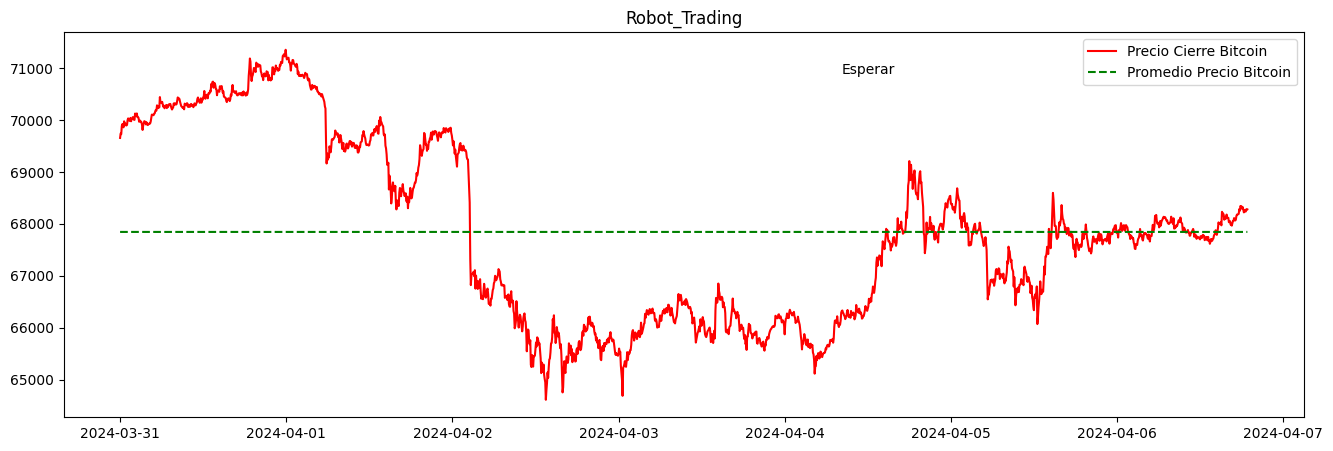

In [80]:
visualizacion()

## 6. Automatización


6. Automatización: Finalmente, ahora que tienes el algoritmo de decisión, es hora de automatizar el proceso. Utiliza la librería de Python "time" para ejecutar el algoritmo de decisión cada 5 minutos y actualizar el gráfico

La variacion de ultima hora: 0.01%
Tendencia Baja
El Precio actual de Bitcoin (USD): 68342.28
<span class="sc-6a54057-0 iEhQde"><span class="icon-Caret-down" style="width:12px;height:18px;display:inline-block"></span>0.01%</span>
0.01%
Numero de valores nulos en la columna 'Close' : 0
No hacer tratamiento de nulos
Datos a remover: (920,)
Datos despues de quitar los ceros en volumen: (1025, 7)


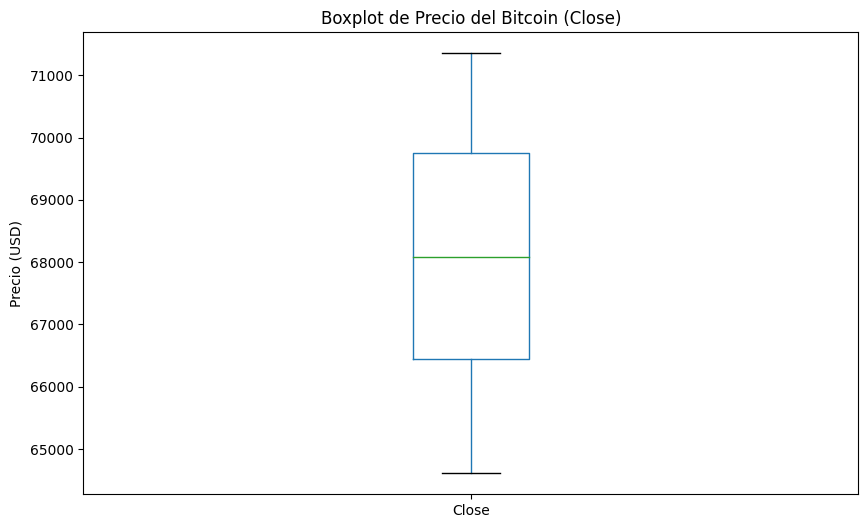

Total del DF sin Outliers: (1025, 7)
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1025 entries, 2024-03-31 00:05:00+00:00 to 2024-04-06 18:00:00+00:00
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          1025 non-null   float64
 1   High          1025 non-null   float64
 2   Low           1025 non-null   float64
 3   Close         1025 non-null   float64
 4   Volume        1025 non-null   int64  
 5   Dividends     1025 non-null   float64
 6   Stock Splits  1025 non-null   float64
dtypes: float64(6), int64(1)
memory usage: 64.1 KB
Info del DF sin Outliers: None
Registros cuyo precio se encuentra entre Q1 y Q3:
Total del DF sin Outliers 1 y 3 Q: (513, 7)
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 513 entries, 2024-03-31 00:05:00+00:00 to 2024-04-06 18:00:00+00:00
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Op

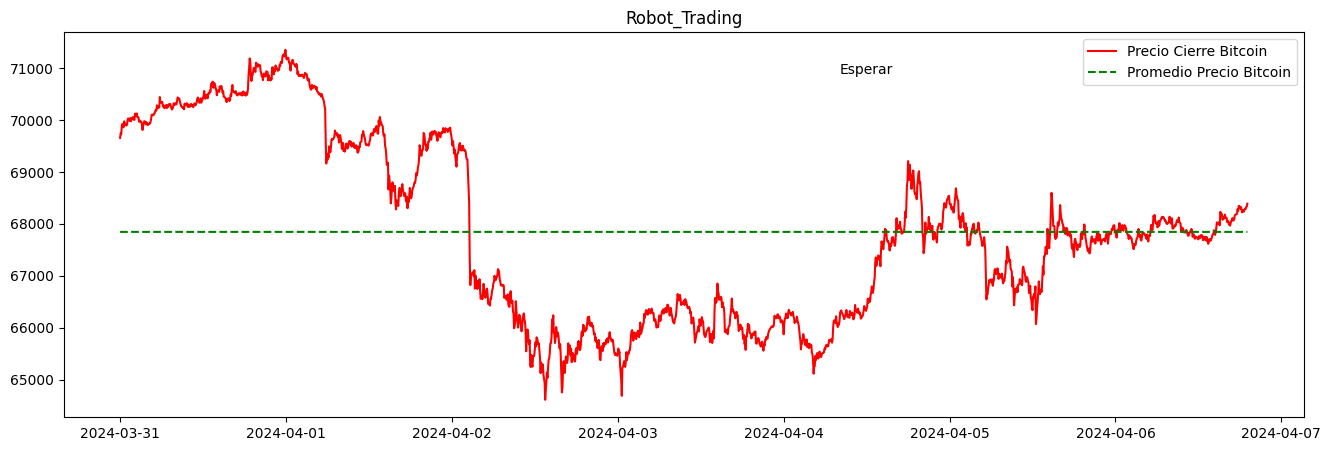

In [ ]:
from IPython.display import clear_output
import time

while(True):
    clear_output()
    importar_base_bitcoin()
    extraer_tendencias('https://coinmarketcap.com/')
    limpieza_datos()
    tomar_decisiones()
    visualizacion()
    time.sleep(300)